# Implementazione del task 6 - Sequence Mining

Data una sequenza di label $s = [l_1, \ldots, l_n]$, una sequenza $p = [\overline{l}_1,\ldots,\overline{l}_m]$ è un **pattern** di $s$ se e solo se esiste una funzione monotona strettamente crescente $f: \{1, \ldots m\} \rightarrow \{1,\ldots, n\}$ tale che per ogni $i \in \{1, \ldots m\}$ abbiamo $l_{f(i)} = \overline{l}_i$; se esiste una tale funzione allora scriveremo $p \in s$, altrimenti scriveremo $p \notin s$.

Dato un multi-insieme di sequenze $S = s_1, \ldots, s_N$ e un pattern $p$, definiamo il supporto di $p \in S$ come $sup_S(p) = \frac {\{i: p \in s_i\}}{N}$.

## Pattern Association Rule

Una Pattern Association Rule $par$ è una regola della forma $s \rightarrow \overline{s}$, dove $s$ e $\overline{s}$ sono sequenze.

Dato un multi-insieme di sequenze $S = s_1, \ldots, s_N$, definiamo il supporto della regola $par \in S$ come $sup_S(par) = sup_S(s \cdot \overline{s})$ in cui $s \cdot \overline{s}$ indica l'operazione di concatenazione tra sequenze.

Inoltre, la confidenza di $par \in S$ è il valore $conf_S(par) = \frac{sup_S(par)}{sup_S(s)}$.

In [1]:
# IMPORT
import nbimporter
import ETLBasics_t1 as task1
import ProfilingBasics_t2 as task2
import TimeSeriesToEvents_t3 as task3
import FeatureReduction_t4 as task4
import MakeTransactions_t5 as task5
import re
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

from pandas.plotting import parallel_coordinates
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter("ignore", UserWarning)

In [2]:
# VARIABILI
PATH = './pmdata/'
people = [1,2,3]

In [3]:
# IPER-PARAMETRI

# raggruppamento task 3
K_GROUP_DAY = 1
K_GROUP_HOUR = 1

# attributi temporali per le label task 5
times_attributes = ['weekend']  #['week_day',]

# parametri del sequence mining task 6
MIN_SUP = 0.09
MIN_CONF = 0.8
MIN_LEN = 1
MAX_LEN = 5

### Implementazione del task 1

In [4]:
sedentary_minutes = task1.sedentary_minutes_to_df(PATH, people)
sleep_0, sleep_1 = task1.sleep_to_df(PATH, people)
exercise_0, exercise_1 = task1.exercise_to_df(PATH, people)
lightly_active_minutes = task1.lightly_active_minutes_to_df(PATH, people)
time_in_heart_rate_zones = task1.time_in_heart_rate_zones_to_df(PATH, people)
moderately_active_minutes = task1.moderately_active_minutes_to_df(PATH, people)
very_active_minutes = task1.very_active_minutes_to_df(PATH, people)
resting_heart_rate = task1.resting_heart_rate_to_df(PATH, people)
srpe = task1.srpe_to_df(PATH, people)
wellness = task1.wellness_to_df(PATH, people)
injury = task1.injury_to_df(PATH, people)

try:
    steps = pd.read_pickle("dataframes/steps.pkl").loc[people]
    distance = pd.read_pickle("dataframes/distance.pkl").loc[people]
    calories = pd.read_pickle("dataframes/calories.pkl").loc[people]
    heart_rate = pd.read_pickle("dataframes/heart_rate.pkl").loc[people]
except:
    steps = task1.steps_to_df(PATH, people)
    distance = task1.distance_to_df(PATH, people)
    calories = task1.calories_to_df(PATH, people)
    heart_rate = task1.heart_rate_to_df(PATH, people)

### Implementazione dei task 3, 4 e 5

Carichiamo le transazioni ricordando che ognuna di esse può essere vista come una sequenza di item (ordinata in base al timestamp).

In [5]:
group_time_series_map = {
    'DAY':  [sedentary_minutes,lightly_active_minutes,moderately_active_minutes,very_active_minutes,resting_heart_rate,time_in_heart_rate_zones],
    'HOUR': [calories]  #,distance,heart_rate,steps
}
event_name = [exercise_0,exercise_1]  #,sleep_0,sleep_1,srpe,wellness,injury

day_kmeans_data = []
hour_kmeans_data = []
event_kmeans_data = []

for df in group_time_series_map['DAY']:
    df = task3.from_ts_to_event_based_data(df,'DAY', K_GROUP_DAY) # questo andrà ad aggiungere per ogni colonna numerica _mean e _std
    df = task4.kmeans_discretization(df)
    day_kmeans_data.append(df)

for df in group_time_series_map['HOUR']:
    df = task3.from_ts_to_event_based_data(df,'HOUR', K_GROUP_HOUR)
    df = task4.kmeans_discretization(df)
    hour_kmeans_data.append(df)

for event in event_name:
    event = task4.kmeans_discretization(event, is_event=True)
    # estraggo le colonna TS per utilizzare la procedura che crea le transazioni
    # Viene estratto dall'indice TS e viene creata la corrispondente colonna TS
    event = event.reset_index(level='TS')
    event['obj_TS'] = [x for x in event['TS']]  # per evitare errori in caso di ricalcolo del task 5
    event_kmeans_data.append(event)

transactions = task5.make_transactions(day_kmeans_data, hour_kmeans_data, event_kmeans_data, times_attributes=times_attributes)

## Sequence Mining

Un elemento fondamentale del data mining è dato dalle regole di associazione, ossia un insieme di regole che consentono di stabilire delle relazioni di implicazione all'interno del dataset (gruppi di affinità) del tipo $X \rightarrow Y$, ovvero se occorre l'evento $X$ in un'istanza allora con molta probabilità si verificherà anche l'evento $Y$.

Costruiremo quindi una funzione `extract_pattern_rules(seq, minsup, minconf, minlen, maxlen)` per estrarre dall'insieme di sequenze $seq$ tutte le Pattern Association Rules con: lunghezza compresa tra $minlen$ e $maxlen$; supporto maggiore di $minsup$; confidenza maggiore di $minconf$.

In [6]:
def extract_pattern_rules(seq, minsup, minconf, minlen, maxlen):
    # creazione di un DataFrame per l'algoritmo apriori con valori True e False nelle colonne (uso della one-hot encoding)
    te = TransactionEncoder()
    onehot = te.fit(seq).transform(seq)
    onehot.astype("int")
    dft = pd.DataFrame(onehot, columns=te.columns_)

    # uso di apriori per il calcolo dei frequent_itemsets da cui verranno poi estratte le regole di associazione
    # utilizziamo il supporto minimo $minsup$
    # vogliamo che l'elemento negli itemset sia rappresentato dai nomi delle colonne $use_colnames=True$
    # $max_len=maxlen+1$ poiché viene escluso l'estremo superiore
    frequent_itemset = apriori(dft, min_support=minsup, max_len=maxlen+1, use_colnames=True)  # ritorna un DataFrame
    
    # utilizziamo la confidenza come metrica per il pruning delle regole
    # estraiamo quindi le regole con confidenza maggiore di $minconf$
    rules = association_rules(frequent_itemset, metric="confidence", min_threshold=minconf)
    
    # scartiamo le regole con lunghezza minima < min (il max è invece controllato direttamente in apriori)
    index = []
    for i in range(len(rules)):
        if minlen<=len(rules.iloc[i]['antecedents'])+ len(rules.iloc[i]['consequents']):
            index.append(i)
    rules = rules.iloc[index]
    # anche qui seleziono alcune regole e non tutte perché nonostante nella parte precedente abbia già applicato
    # vincoli su confidence e min_support a livello di temporal AR questi valori potrebbero abbassarsi,
    # quindi è necessario rincontrollare i vincoli

    # usiamo le espressioni regolari per identificare i pattern
    # dobbiamo usare un separatore speciale che NON appaia in NESSUNA transazione
    SEP = '<!>'
    index = []
    for i in range(len(rules)):  # ogni regola in rules forma un pattern
        pattern_complete_rule = list(rules.iloc[i]['antecedents']) + list(rules.iloc[i]['consequents'])
        pattern_re = '.*'.join([ re.escape(SEP + i + SEP) for i in pattern_complete_rule])
    
        c = 0
        for tr in seq:
            ttext = SEP + (SEP + SEP).join(tr) + SEP
            search = re.search(pattern_re, ttext)
            c = c + 1 if search else c 
        sup_rule = c/len(seq)
        
        pattern_antecedent = list(rules.iloc[i]['antecedents'])
        pattern_re = '.*'.join([ re.escape(SEP + i + SEP) for i in pattern_antecedent])

        c = 0
        for tr in seq:
            ttext = SEP + (SEP + SEP).join(tr) + SEP
            search = re.search(pattern_re, ttext)
            c = c + 1 if search else c 
        sup_antecedent = c/len(seq)

        if sup_antecedent >= minsup and sup_rule/sup_antecedent >= minconf:
            index.append(i)
    
    return rules.iloc[index]

### Implementazione del task 6

In [7]:
# ordiniamo le istanze dentro la transazione rispetto al timestamp (primo parametro)
for tr in transactions:
    tr.sort(key = lambda x: x[0])

# estraiamo solo le labels dimenticandoci dei timestamp
sequence_labels = [[i[1] for i in tr] for tr in transactions]
rules = extract_pattern_rules(sequence_labels, MIN_SUP, MIN_CONF, MIN_LEN, MAX_LEN)

### Visualizzazione delle regole tramite heatmap

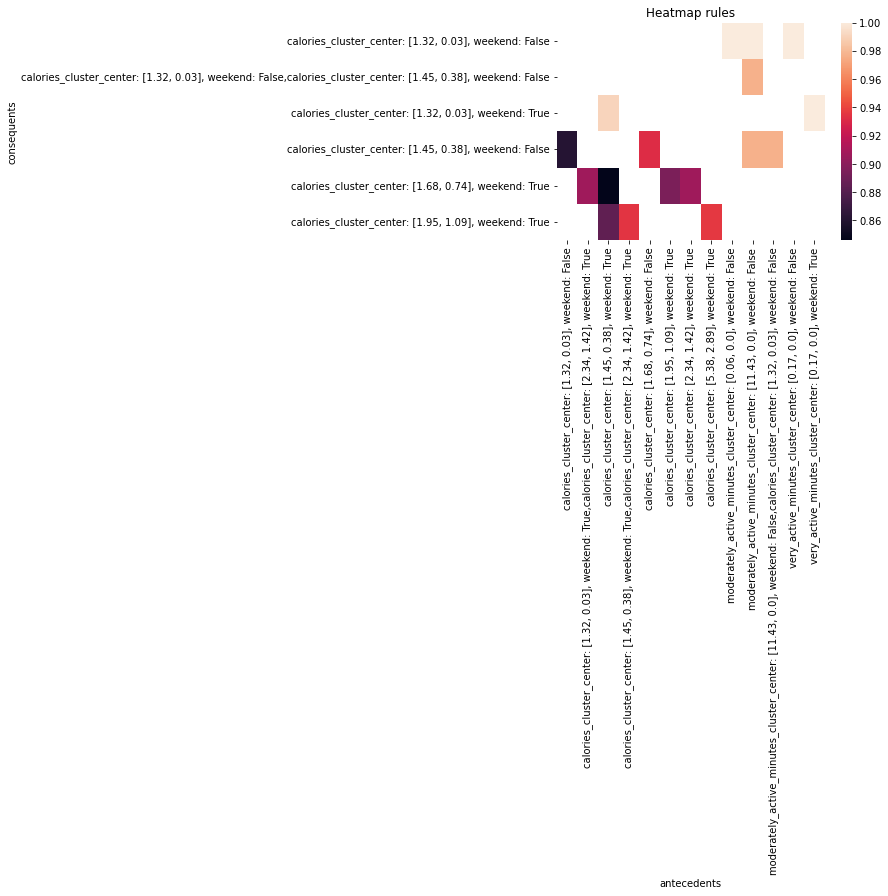

In [8]:
heatmap_rules = rules.copy()

# trasformiamo antecedenti e conseguenti in liste ai fini della visualizzazione
heatmap_rules['antecedents'] = heatmap_rules['antecedents'].apply(lambda a: ','.join(list(a))) 
heatmap_rules['consequents'] = heatmap_rules['consequents'].apply(lambda a: ','.join(list(a)))

support_table = heatmap_rules.pivot(index='consequents', columns='antecedents', values='confidence')
sns.heatmap(support_table, annot=False)

plt.rcParams['figure.figsize'] = [15, 15]
plt.title("Heatmap rules")
plt.show()

### Visualizzazione delle regole tramite coordinate parallele

Le coordinate parallele sono utili per concentrarsi sulle proprietà qualitative degli itemset. Ad esempio, un evento non coinvolto in alcun antecedente potrebbe invece essere conseguente in molte regole.

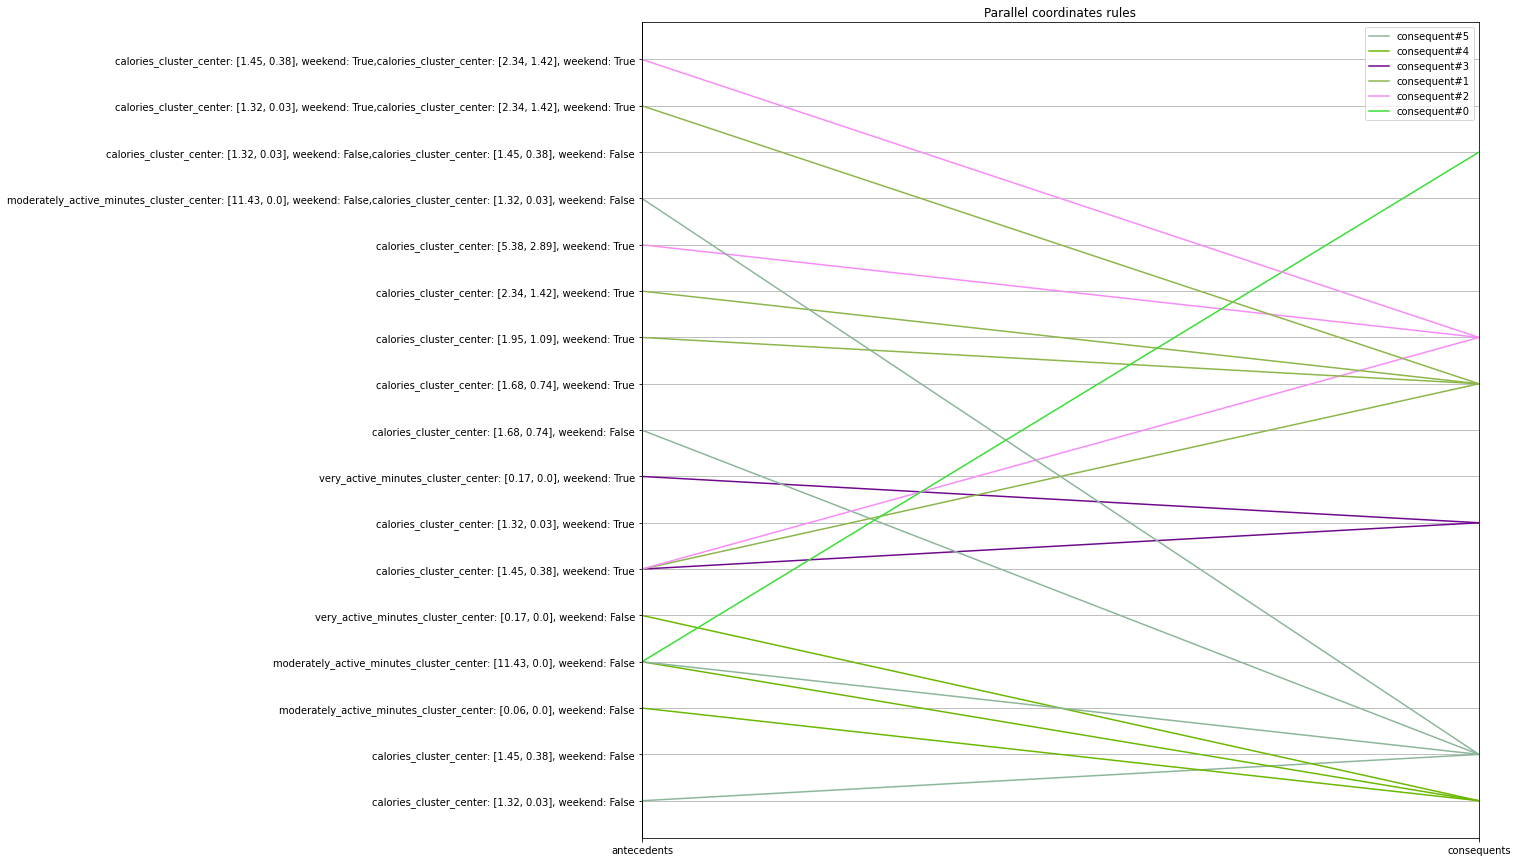

In [9]:
par_cor_rules = rules.copy()

_map = {value:str(key) for (key, value) in dict(enumerate(set(par_cor_rules['consequents']))).items() }
par_cor_rules['consequent_class'] = par_cor_rules['consequents'].apply(lambda x: "consequent#"+_map[x])

# trasformiamo antecedenti e conseguenti in liste ai fini della visualizzazione
par_cor_rules['antecedents'] = par_cor_rules['antecedents'].apply(lambda a: ','.join(list(a)))
par_cor_rules['consequents'] = par_cor_rules['consequents'].apply(lambda a: ','.join(list(a)))

parallel_coordinates(par_cor_rules[['antecedents','consequents','consequent_class']], 'consequent_class')
plt.rcParams['figure.figsize'] = [15, 15]
plt.title("Parallel coordinates rules")
plt.show()